In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROUTH'] = 'true'

In [5]:
exercise = 'exer1'

In [6]:
tr_set_group = sorted([x for x in Path(f"./dataset/{exercise}/seq/").glob("*.npy")])
tr_set_group

[WindowsPath('dataset/exer1/seq/seq_little_1670082995.npy'),
 WindowsPath('dataset/exer1/seq/seq_little_1670083079.npy'),
 WindowsPath('dataset/exer1/seq/seq_thumb_1670082995.npy'),
 WindowsPath('dataset/exer1/seq/seq_thumb_1670083079.npy')]

In [7]:
actions = ['thumb','paper']

In [8]:
data = []

for fle in tr_set_group:
    if len(data) == 0:
        data = np.load(fle)
    else:
        data = np.concatenate([data, np.load(fle)], axis=0)

In [9]:
print(data.shape)
print(data[0][-1])

(2055, 30, 100)
[ 6.25918388e-01  5.90298712e-01 -3.07661480e-07  0.00000000e+00
  6.49076819e-01  5.44179380e-01  5.23972558e-03  0.00000000e+00
  6.53718233e-01  4.96857941e-01  1.15060275e-02  0.00000000e+00
  6.37362599e-01  4.65235889e-01  1.66208260e-02  0.00000000e+00
  6.18655205e-01  4.54011291e-01  2.18164902e-02  0.00000000e+00
  6.07456863e-01  4.38670427e-01  1.07005425e-02  0.00000000e+00
  5.80796480e-01  4.27315176e-01  1.37827946e-02  0.00000000e+00
  5.73692560e-01  4.40656185e-01  1.61442272e-02  0.00000000e+00
  5.76137722e-01  4.56456125e-01  1.76963247e-02  0.00000000e+00
  5.83384514e-01  4.48403656e-01  7.10306922e-03  0.00000000e+00
  5.61155796e-01  4.51364219e-01  8.26031715e-03  0.00000000e+00
  5.62662721e-01  4.72303987e-01  7.44483108e-03  0.00000000e+00
  5.69637895e-01  4.88713950e-01  6.33986155e-03  0.00000000e+00
  5.64535856e-01  4.71386284e-01  3.58748296e-03  0.00000000e+00
  5.38593471e-01  4.69211459e-01 -2.49453378e-03  0.00000000e+00
  5.37776

In [10]:
x_data = data[:,:,:-1]
labels = data[:,0,-1]

print(x_data.shape)
print(labels.shape)

(2055, 30, 99)
(2055,)


In [11]:
y_data = to_categorical(labels, num_classes=len(actions))
print(y_data.shape)

(2055, 2)


In [12]:
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_tr,x_val,y_tr,y_val = train_test_split(x_data, y_data, test_size=0.1, shuffle=True, random_state= 3)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(1849, 30, 99) (1849, 2)
(206, 30, 99) (206, 2)


In [13]:
print(x_tr.shape[1:3])

(30, 99)


In [14]:
model = Sequential([
    LSTM(64, activation = 'relu', input_shape = x_tr.shape[1:3]),
    Dense(32, activation = 'relu'),
    Dense(16, activation ='relu'),
    Dense(len(actions), activation = 'softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 44,626
Trainable params: 44,626
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(
    x_tr, y_tr,
    validation_data = (x_val, y_val),
    epochs = 1000,
    callbacks=[
        ModelCheckpoint(f'models/{exercise}/classifier_acc.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ModelCheckpoint(f'models/{exercise}/classifier_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.05, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_loss', min_delta=0, patience=200, mode='auto')
    ]
)

Epoch 1/1000
55/58 [===========================>..] - ETA: 0s - loss: 32.8993 - acc: 0.5744
Epoch 1: val_acc improved from -inf to 0.55825, saving model to models/exer1\classifier_acc.h5

Epoch 1: val_loss improved from inf to 29.72185, saving model to models/exer1\classifier_loss.h5
58/58 [==============================] - 3s 23ms/step - loss: 33.2096 - acc: 0.5717 - val_loss: 29.7218 - val_acc: 0.5583 - lr: 0.0010
Epoch 2/1000
56/58 [===========================>..] - ETA: 0s - loss: 13.9300 - acc: 0.6412
Epoch 2: val_acc improved from 0.55825 to 0.75728, saving model to models/exer1\classifier_acc.h5

Epoch 2: val_loss improved from 29.72185 to 8.58111, saving model to models/exer1\classifier_loss.h5
58/58 [==============================] - 1s 22ms/step - loss: 13.7252 - acc: 0.6425 - val_loss: 8.5811 - val_acc: 0.7573 - lr: 0.0010
Epoch 3/1000
57/58 [============================>.] - ETA: 0s - loss: 16.0771 - acc: 0.6245
Epoch 3: val_acc did not improve from 0.75728

Epoch 3: val_lo

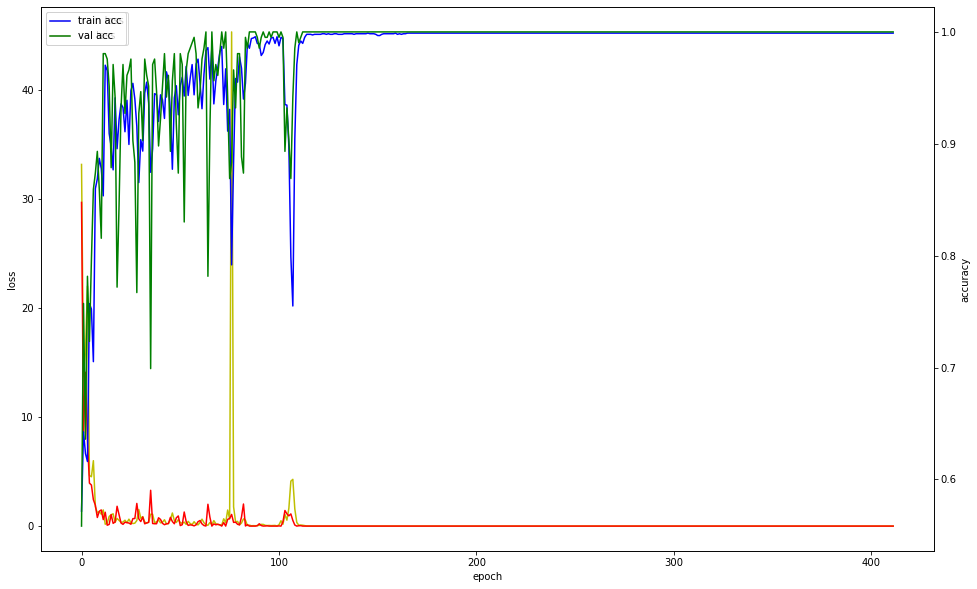

In [17]:
fig, loss_ax = plt.subplots(figsize=(16,10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'],'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'],'b', label='train acc')
acc_ax.plot(history.history['val_acc'],'g',label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()